
# Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from raft_functions import *


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).
The video we will use here is free of use from [pexels.com](https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/),
credits go to [Pavel Danilyuk](https://www.pexels.com/@pavel-danilyuk).



:func:`~torchvision.io.read_video` returns the video frames, audio frames and
the metadata associated with the video. In our case, we only need the video
frames.

Here we will just make 2 predictions between 2 pre-selected pairs of frames,
namely frames (100, 101) and (150, 151). Each of these pairs corresponds to a
single model input.



In [3]:
from torchvision.io import read_video
from torch import from_numpy
import skimage
def load_image_batches(path, step = 10, smooth = 5):
    # path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_03.mp4"

    frames, _, _ = read_video(str(path), output_format="TCHW") # returns video frames, audio frames, metadata for the video and audio
    # print(frames.shape)
    images1 = []
    images2 = []
    img = np.array([np.moveaxis(frames[a].numpy()[:,:,:], 0, -1) for a in range(len(frames))])
    # print(img.shape)
    # print(sm.structural_similarity(img[0, 200:500, 600:900, 0], img[1, 200:500, 600:900, 0]))
    # len(frames)-2
    for i in range(0, len(frames)-2, step):
        img1 = img[i, 100:600, 500:1000, :]
        img2 = img[i+1, 100:600, 500:1000, :]
        if (sm.structural_similarity(img1[:,:,0], img2[:,:,0]) < 0.90):
            # print(sm.structural_similarity(img[i, 200:500, 600:900, 0], img[i+1, 200:500, 600:900, 0]))
            # plt.imshow(img1, cmap = 'gray'), plt.show()
            # plt.imshow(img[i+1, 200:500, 600:900, 0], cmap = 'gray'), plt.show()
            # blur = cv2.bilateralFilter(img1, smooth, 160, 160)
            # blurred = np.moveaxis(blur, -1, 0)
            # blurred2 = np.moveaxis(cv2.bilateralFilter(img2,smooth,160,160), -1, 0)
            # print(img1.dtype)
            new_shape = (img1.shape[0] , img1.shape[1] , img1.shape[2])
            blurred1 = skimage.transform.resize(image=img1, output_shape=new_shape).astype(np.float32)
            blurred2 = skimage.transform.resize(image=img2, output_shape=new_shape).astype(np.float32)
            # print(blurred1.shape)

            blurred_1 = np.moveaxis(cv2.bilateralFilter(blurred1,smooth,160,160), -1, 0)
            blurred_2 = np.moveaxis(cv2.bilateralFilter(blurred2,smooth,160,160), -1, 0)

            # print(blurred.shape)
            # plt.imshow(blurred, cmap= 'gray'), plt.show()
            images1.append(torch.from_numpy(blurred_1))
            images2.append(torch.from_numpy(blurred_2))
            # images1.append(frames[i, :, 200:500, 600:900])
            # images2.append(frames[i+1, :, 200:500, 600:900])

    if len(images2) < 1: #when the video is too short/ redundant video
        img1_batch = images1
        img2_batch = images2
    else:
        img1_batch = torch.stack(images1) # making predictions between 2 pairs of frames 53 and 83, and 84 and 130
        img2_batch = torch.stack(images2)

    return img1_batch, img2_batch

In [17]:
from torchvision.io import read_video
from torch import from_numpy
import skimage
from skimage import metrics as sm
import numpy as np
import cv2

def load_image_batches_all(paths, step = 10, smooth = 5):
    # path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/Participant_12/Processed_data/Video/Subject_12_03.mp4"
    img1_batch_all = []
    img2_batch_all = []

    for num, path in enumerate(paths):
        img1_batch, img2_batch = load_image_batches(path, step, smooth)
        if len(img1_batch) < 1: continue
        img1_batch_all.append(img1_batch)
        img2_batch_all.append(img2_batch)

    return img1_batch_all, img2_batch_all

In [4]:
# Check if the file path exists for the initial video
import os
# home
# path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/notext/Participant_12_no_labels/Processed_data/Video/Subject_12_03.mp4"

#SEMI WORKING
path = "C:/Users/Misha/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/segment_A Taal)dcmekf.mp4"
# path = "/Users/men22/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/segment_ad Laat #)ebsoht.mp4"

print("file exists?", os.path.exists(path))

file exists? True


In [4]:
import glob

# function to extract the paths for files froma path
def load_paths(data_path):
    files = []
    files.append(glob.glob(data_path, 
                recursive = True))
    return files[0]

In [18]:
paths = load_paths("/Users/men22/OneDrive - University of Sussex/FYP/Participants/VIDEOS_ALL/*.mp4")
len(paths)

1397

In [6]:
img1_batch, img2_batch = load_image_batches(path, 1, 24)

c:\Users\Misha\anaconda3\envs\fyp\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [20]:
len(img1_batch)

1154

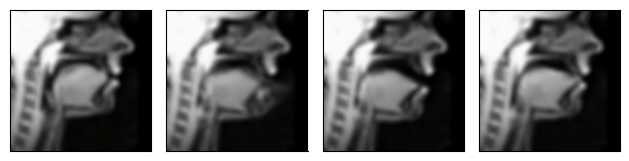

In [9]:
plot(img1_batch[0])

In [10]:

from torchvision.models.optical_flow import Raft_Large_Weights

from torchvision.models.optical_flow import raft_large

def preprocess(img1_batch, img2_batch, transf = 'large', s = 336):
    if transf == 'large':
        weights = Raft_Large_Weights.DEFAULT
    else: 
        weights = Raft_Small_Weights.DEFAULT
    transforms = weights.transforms()
    # img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    # img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    img1_batch = F.resize(img1_batch, size=[s, s], antialias=False) # resize frames to ensure they are divisable by 8 
    img2_batch = F.resize(img2_batch, size=[s, s], antialias=False)
    return transforms(img1_batch, img2_batch)

def raft(img1_batch, img2_batch, raft_ = 'large', device = 'cpu'):
    # set the weights
    if raft_ == 'large':
        weights = Raft_Large_Weights.DEFAULT
    else: 
        weights = Raft_Small_Weights.DEFAULT
    # prepare the images for the model
    # img1_batch, img2_batch = preprocess(img1_batch, img2_batch, transf = raft_, s = s)
    # create model
    model = raft_large(weights, progress=False).to(device)
    model = model.eval()

    # get list of predictions
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
    # get the last one - most accurate
    predicted_flow = list_of_flows[-1]

    return predicted_flow


In [8]:
from raft_functions import *

In [11]:
# from raft_functions import raft
size = 336
img1__batch, img2__batch = preprocess(img1_batch[0], img2_batch[0], s = size)
predicted_flow1 = raft(img1__batch, img2__batch)

/Applications/Anaconda/envs/fyp/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [12]:
def flows_all(img1_batch, img2_batch, s = 336):
    
    img1__batch_all = []
    img2__batch_all = []
    flows = []

    for i in range(len(img1_batch)):
        img1__batch, img2__batch = preprocess(img1_batch[i], img2_batch[i], s = 336)
        img1__batch_all.append(img1__batch)
        img2__batch_all.append(img2__batch)
        predicted_flow = raft(img1__batch, img2__batch)
        flows.append(predicted_flow)

    return img1__batch_all, img2__batch_all, flows

In [21]:
img1__batch, img2__batch, flows = flows_all(img1_batch, img2_batch)

/Applications/Anaconda/envs/fyp/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
import pickle
with open('flows1.pickle','wb') as temp:
  pickle.dump([img1__batch, img2__batch, flows], temp)

Error: Session cannot generate requests

In [ ]:
len(flows)

Error: Session cannot generate requests

In [3]:
import pickle
with open('flows1.pickle','rb') as temp:
    a,b,c = pickle.load(temp)

print(a)
print(b)
print(c)

[tensor([[[[ 0.9638,  0.9643,  0.9648,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9637,  0.9641,  0.9646,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9636,  0.9639,  0.9642,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5431, -0.5416, -0.5362,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5492, -0.5480, -0.5431,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5517, -0.5506, -0.5460,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.9795,  0.9800,  0.9804,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9793,  0.9798,  0.9803,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9793,  0.9796,  0.9799,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.5274, -0.5259, -0.5205,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5335, -0.5323, -0.5275,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5360, -0.5349, -0.5303,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.9559,  0.9564,  0.9569,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.9558,  0.9563, 

In [ ]:
def convert_flow(predicted_flows):
    flows_tchw = [predicted_flows[a].detach().numpy()[:,:,:] for a in range(predicted_flows.shape[0])] # make it back to numpy arrays for all N predicted flows
    flows = np.moveaxis(flows_tchw, 1, -1) # change the dimmensions from TCHW to THWC
    return flows

In [ ]:
def convert_images(img_batch):
    # print(img_batch.shape)
    img2_batch = [(img2 + 1) / 2 for img2 in img_batch] # upsampling the image back to original
    # print(len(img2_batch))
    img2 = np.array([np.moveaxis(img2_batch[a].numpy()[:,:,:], 0, -1) for a in range(len(img_batch))])
    return img2

In [41]:
images = convert_images(img1__batch)
# blurred  = cv2.bilateralFilter(images[0],9,75,75)
# blurred.shape
images.shape

(7, 352, 352, 3)

(352, 352, 3)
(88, 88, 3)


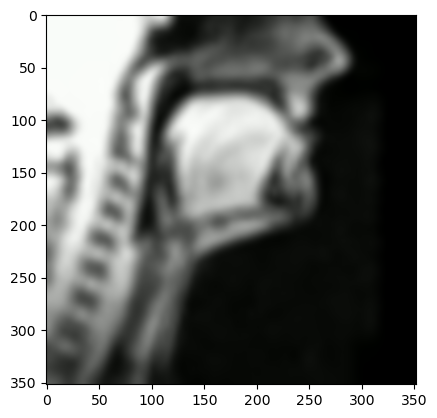

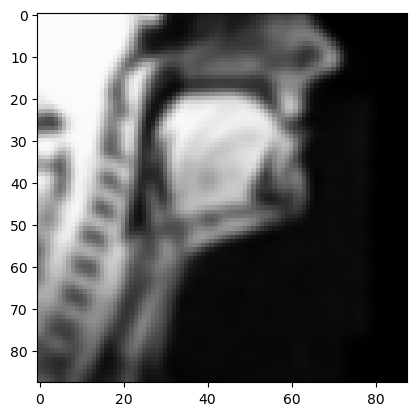

(<matplotlib.image.AxesImage at 0x2688535a970>, None)

In [42]:
new_shape = (images[0].shape[0] //4, images[0].shape[1] // 4, images[0].shape[2])
small = skimage.transform.resize(image=images[0], output_shape=new_shape)
print(images[0].shape)
print(small.shape)
plt.imshow(images[0]), plt.show()
plt.imshow(small), plt.show()

In [ ]:
blur = cv2.bilateralFilter(small,5,160,160)
plt.imshow(blur)

In [ ]:
print(predicted_flow1.shape)
flows = convert_flow(predicted_flow1)
flows.shape

In [62]:
import flowpy

def warp_flow(img, flow):
   h, w = flow.shape[:2]
   flow = -flow #getting next from previous - if the opposite - getting previous from current - need to invert the flow
   flow[:,:,0] += np.arange(w)
   flow[:,:,1] += np.arange(h)[:,np.newaxis]
   res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
   return res

def evaluate_raft_2(img1_batch, img2_batch, predicted_flows, remapping = 'forward'):
    print(img1_batch.shape)
    # img1__batch, img2__batch = preprocess(img1_batch, img2_batch,s = 248)
    # plot(img1_batch)
    # print(img1__batch.shape)
    images1 = convert_images(img1_batch) # all frames 1
    images2 = convert_images(img2_batch) # all frames 2
    print(images1.shape)
    flows = convert_flow(predicted_flows)
    # print(flows.shape)
    # print(images1[1, :,:,0].shape)
    # print(flows[1, :, :, :].shape)
    # img1 = images2[20, :,:,0]
    # flow1 = flows[20, :, :, :]
    # plt.imshow(draw_flow(img1, flow1, step=16)), plt.show()
    similarity = []
    mapped = []
    if remapping == 'forward':
        for i in range(len(flows)):
            flows[np.isnan(flows)] = 0
            mapped.append(flowpy.forward_warp(images1[i], flows[i]))
            draw_process_evaluate(images1[i], images2[i],flowpy.forward_warp(images1[i], flows[i]))
            plt.imshow(draw_flow(images1[i][:,:,0], -flows[i][:,:,:], step=13)), plt.show()
            similarity.append([sm.structural_similarity(images2[i][: , :, 0], mapped[i][:, :, 0], data_range= 1)])
            print()
        
    else:
        for i in range(len(flows)):
            # mapped.append(remap_backward(images2[i], flows[i][:,:,:]))
            # draw_process_evaluate(images2[i], images1[i], remap_backward(images2[i], flows[i][:,:,:]))
            mapped.append(flowpy.backward_warp(images2[i], flows[i]))
            draw_process_evaluate(images2[i], images1[i], flowpy.backward_warp(images2[i], flows[i]))
            plt.imshow(draw_flow(images2[i][:,:,0], flows[i][:,:,:], step=12)), plt.show()
            similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0], data_range=1)])
        # for i in range(len(flows)):
        #     mapped.append(warp_flow(images2[i], flows[i]))
        #     draw_process_evaluate(images2[i], images1[i], warp_flow(images2[i], flows[i]))
        #     plt.imshow(draw_flow(images2[i][:,:,0], flows[i][:,:,:], step=10)), plt.show()
        #     similarity.append([sm.structural_similarity(images1[i][: , :, 0], mapped[i][:, :, 0], data_range=1)])
    
    print(np.mean(similarity))
    return np.mean(similarity)

In [ ]:
def remap_forward(image, flow):
    flow[np.isnan(flow)] = 0
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    xv, yv = np.meshgrid(x,y)
    map_x = -flow[:, :, 0] + xv
    map_y = -flow[:, :, 1] + yv

    mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR) #pull back mapping to avoid holes in the image
    return mapped_img



# def remap_forward(image, flow):
#     # Compute the x and y coordinates of each pixel in the input image
#     x = np.arange(image.shape[1])
#     y = np.arange(image.shape[0])
#     xv, yv = np.meshgrid(x, y)

#     # Compute the new x and y coordinates of each pixel using the flow values
#     map_x = xv + flow[..., 0]
#     map_y = yv + flow[..., 1]

#     # Remap the input image to the new coordinates using bilinear interpolation
#     mapped_img = cv2.remap(image, map_x.astype(np.float32), map_y.astype(np.float32), cv2.INTER_LINEAR)

#     return mapped_img

In [ ]:
img2__batch[0].shape

torch.Size([2, 3, 336, 336])
(2, 336, 336, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


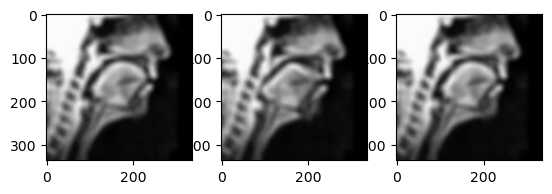

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9304931955720016


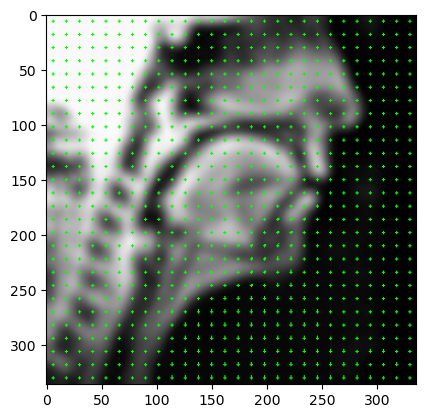

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


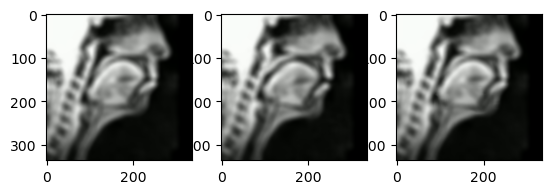

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9360037373286244


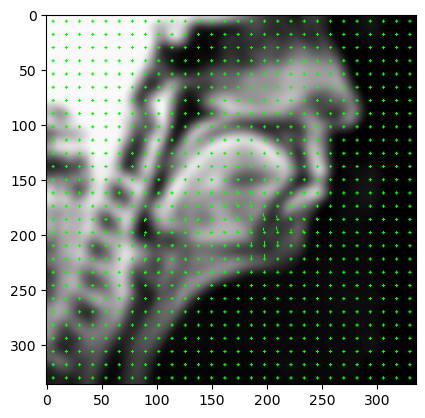

0.933248466450313


In [70]:
# from raft_functions import evaluate_raft
evaluation = evaluate_raft_2(img1__batch[0], img2__batch[0], flows[0], 'backward')
print(evaluation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 336, 336])
(2, 336, 336, 3)


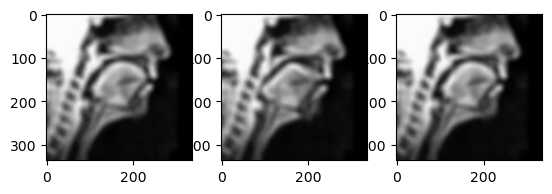

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9304931955720016


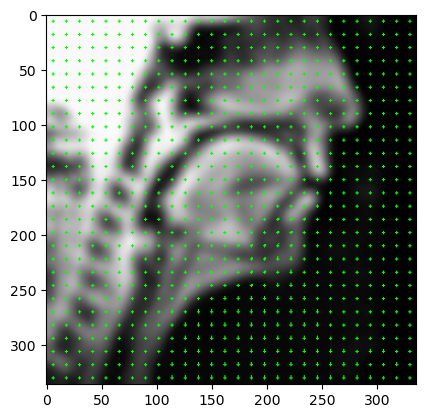

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


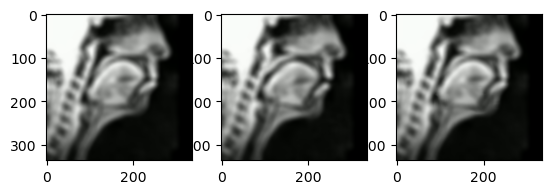

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9360037373286244


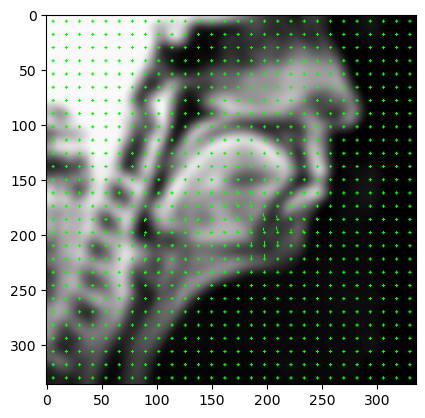

torch.Size([2, 3, 336, 336])
(2, 336, 336, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


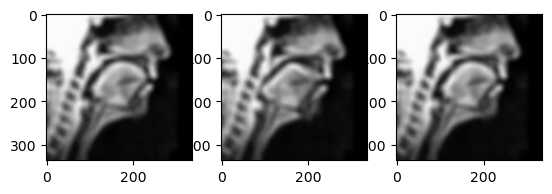

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9304931955720016


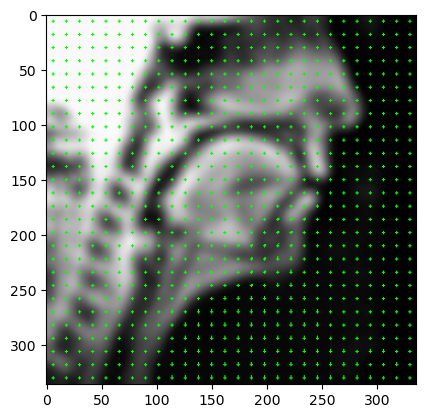

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


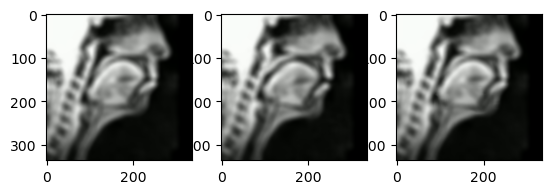

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9360037373286244


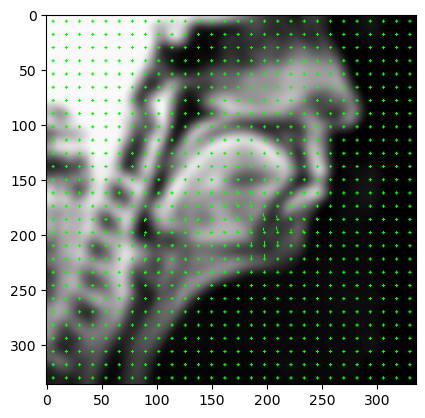

torch.Size([2, 3, 336, 336])
(2, 336, 336, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


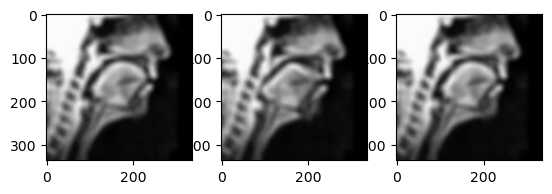

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9304931955720016


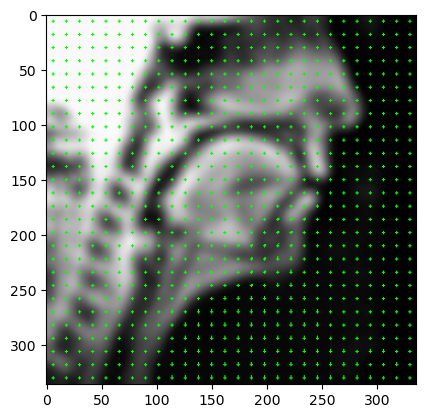

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


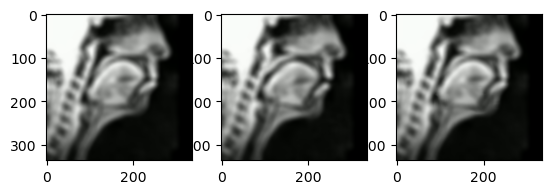

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9360037373286244


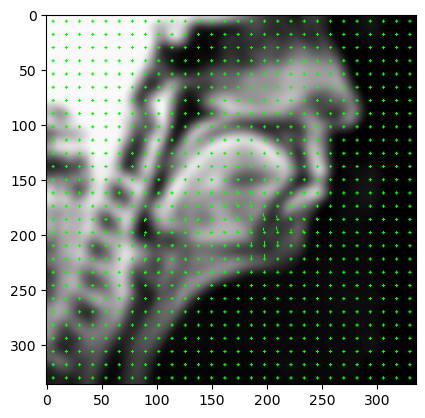

torch.Size([2, 3, 336, 336])
(2, 336, 336, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


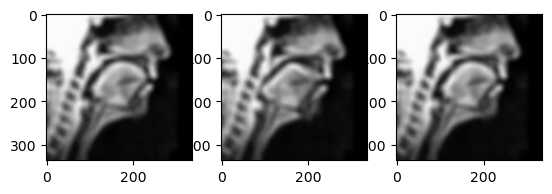

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9304931955720016


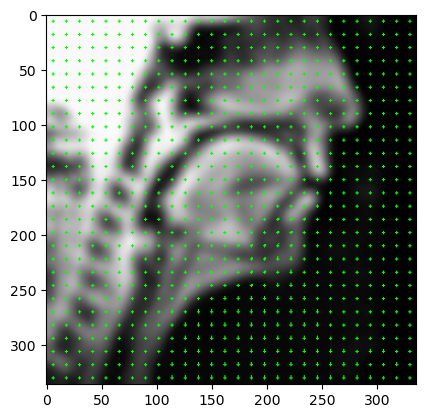

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


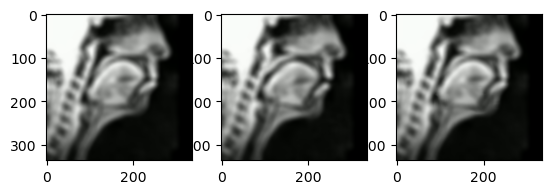

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structural similarity between the 2 images: 0.9360037373286244


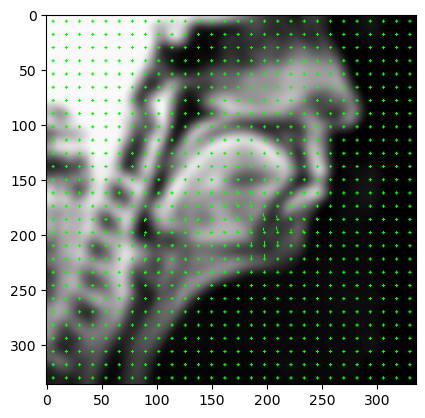

In [71]:
for a in range(len(flows)):
    evaluate_raft_2(img1__batch[0], img2__batch[0], flows[0], 'backward')